In [1]:
import math
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import skimage
from scipy import fft
from scipy import ndimage as ndi
from scipy import signal
from skimage import color, data, draw
from skimage import exposure as exp
from skimage import feature as feat
from skimage import filters, graph, img_as_float, io, measure
from skimage import morphology as morph
from skimage import segmentation as seg
from skimage import transform as trans
from skimage import util
from skimage.filters import rank, thresholding
from skimage.morphology import disk, square

In [2]:
IMAGE_DIR = Path(".") / "data" / "images"

In [3]:
def rescale(img):
    p2, p98 = np.percentile(img, (2, 98))
    rescaled = exp.rescale_intensity(img, in_range=(p2, p98))
    return rescaled

In [4]:
suffixes = (".jpeg", ".png")

PATHS = [p for p in IMAGE_DIR.glob("*.*") if p.suffix in suffixes]
path = PATHS[0]

(dtype('uint8'), 18, 254)

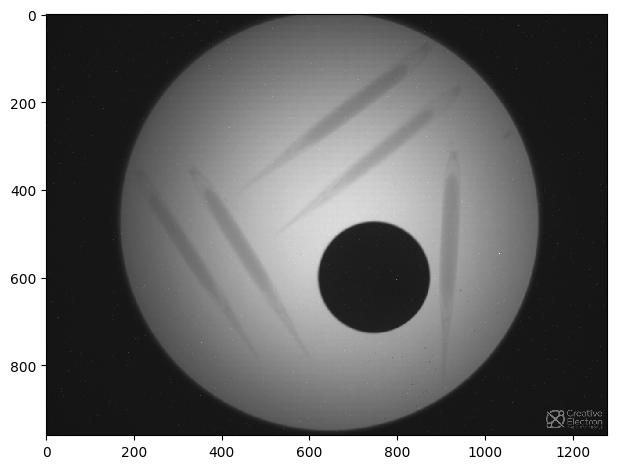

In [5]:
orig = io.imread(path)
gray = np.uint8(color.rgb2gray(orig) * 255.0)
io.imshow(gray)
gray.dtype, gray.min(), gray.max()

(dtype('bool'), False, True)

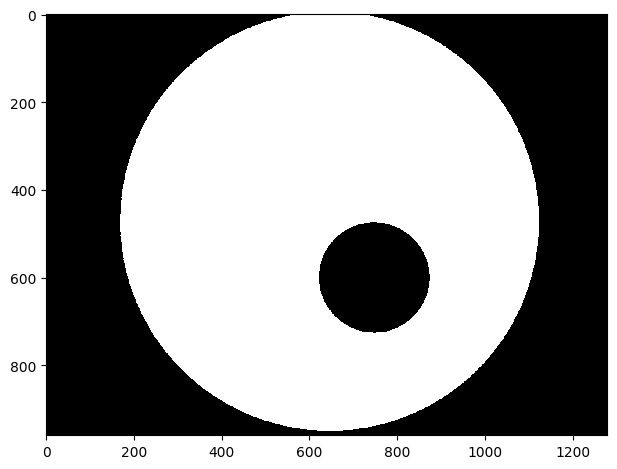

In [6]:
mask = 48 < gray
io.imshow(mask)

mask = morph.binary_erosion(mask)

rr, cc = draw.rectangle((750, 1100), mask.shape, shape=mask.shape)
mask[rr, cc] = 0

io.imshow(mask)
mask.dtype, mask.min(), mask.max()

In [7]:
def auto_level(image):
    footprint = disk(20)

    loc_autolevel = filters.rank.autolevel(image, footprint=footprint)

    loc_perc_autolevel1 = filters.rank.autolevel_percentile(
        image, footprint=footprint, p0=0.01, p1=0.99, mask=mask
    )
    loc_perc_autolevel5 = filters.rank.autolevel_percentile(
        image, footprint=footprint, p0=0.05, p1=0.95, mask=mask
    )
    loc_perc_autolevel10 = filters.rank.autolevel_percentile(
        image, footprint=footprint, p0=0.1, p1=0.9, mask=mask
    )
    loc_perc_autolevel15 = filters.rank.autolevel_percentile(
        image, footprint=footprint, p0=0.15, p1=0.85, mask=mask
    )

    loc_perc_autolevel20 = filters.rank.autolevel_percentile(
        image, footprint=footprint, p0=0.20, p1=0.80, mask=mask
    )

    loc_perc_autolevel30 = filters.rank.autolevel_percentile(
        image, footprint=footprint, p0=0.30, p1=0.70, mask=mask
    )

    loc_perc_autolevel40 = filters.rank.autolevel_percentile(
        image, footprint=footprint, p0=0.40, p1=0.60, mask=mask
    )

    fig, axes = plt.subplots(
        nrows=3, ncols=3, figsize=(10, 10), sharex=True, sharey=True
    )
    ax = axes.ravel()

    image_list = {
        "original": image,
        "auto_level": loc_autolevel,
        "auto-level 1%": loc_perc_autolevel1,
        "auto-level 5%": loc_perc_autolevel5,
        "auto-level 10%": loc_perc_autolevel10,
        "auto-level 15%": loc_perc_autolevel15,
        "auto-level 20%": loc_perc_autolevel20,
        "auto-level 30%": loc_perc_autolevel30,
        "auto-level 40%": loc_perc_autolevel40,
    }

    for i, (title, image) in enumerate(image_list.items()):
        ax[i].imshow(image, cmap=plt.cm.gray, vmin=0, vmax=255)
        ax[i].set_title(title)
        ax[i].axis("off")
    plt.tight_layout()

    return image_list

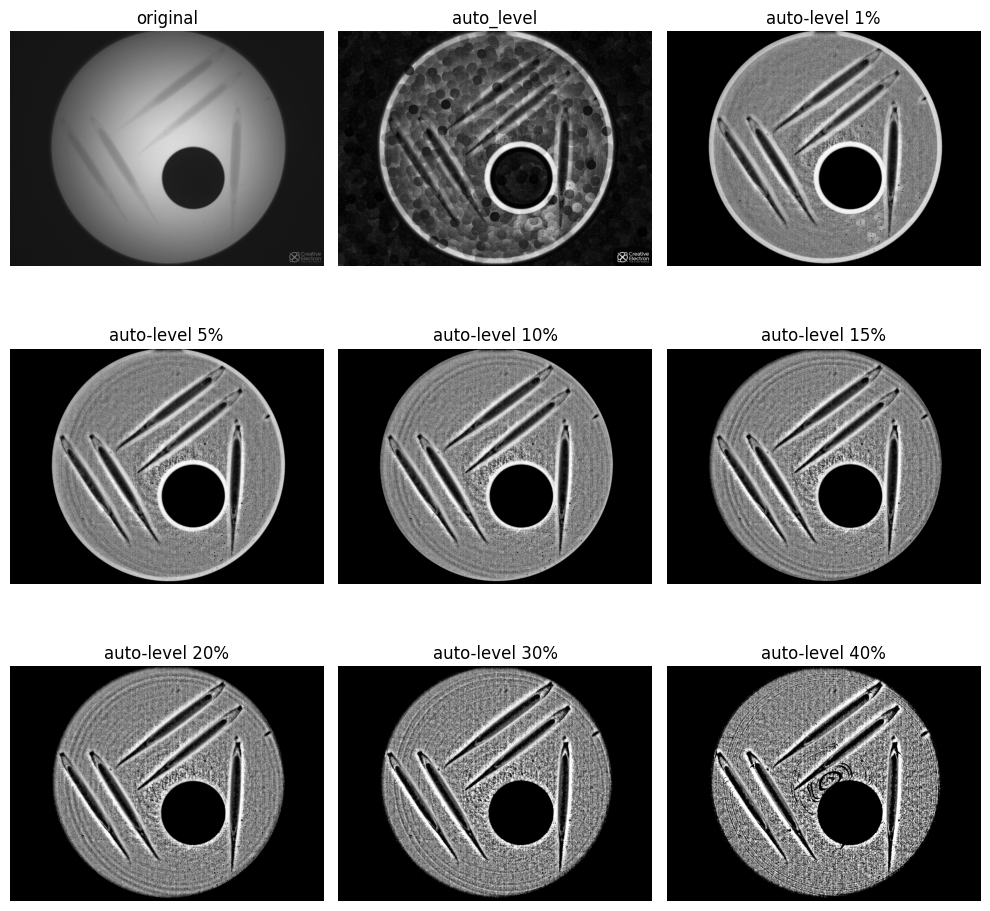

In [8]:
autos = auto_level(gray)

In [9]:
# rev_autos = auto_level(util.invert(gray))

In [10]:
# rev_rev = util.invert(rev_autos["auto-level 1%"])
# io.imshow(rev_rev)

In [11]:
def find_edges(image):
    mean1 = rank.mean(image, disk(10))
    mean1 = rescale(mean1)

    min1 = rank.minimum(mean1, disk(5))
    min1 = rescale(min1)

    mean2 = rank.mean(min1, disk(10))
    mean2 = rescale(mean2)

    edges1 = np.uint8(feat.canny(mean2, sigma=1) * 255.0)
    edges3 = np.uint8(feat.canny(mean2, sigma=3) * 255.0)

    fig, axes = plt.subplots(
        nrows=2, ncols=3, figsize=(15, 10), sharex=True, sharey=True
    )
    ax = axes.ravel()

    image_list = {
        "original": image,
        "mean 1": mean1,
        "min 1": min1,
        "mean 2": mean2,
        "edges sigma = 1": edges1,
        "edges sigma = 3": edges3,
    }

    for i, (title, image) in enumerate(image_list.items()):
        ax[i].imshow(image, cmap=plt.cm.gray, vmin=0, vmax=255)
        ax[i].set_title(title)
        ax[i].axis("off")
    plt.tight_layout()

    return image_list

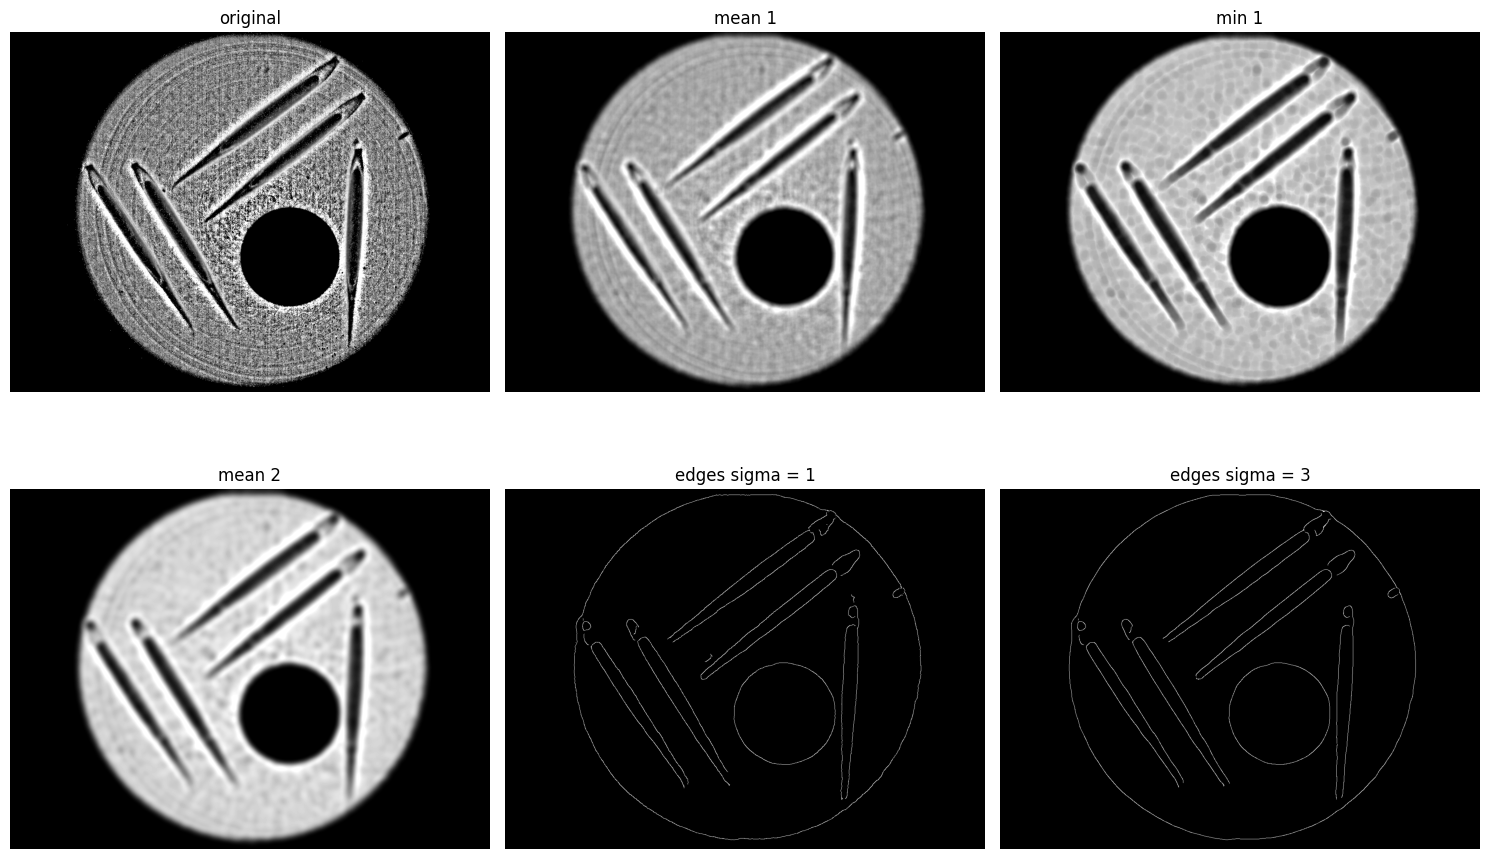

In [18]:
edges = find_edges(autos["auto-level 30%"])

In [13]:
# rev_edges = find_edges(rev_autos["auto-level 1%"])
# rev_edges = find_edges(rev_rev)

In [19]:
def remove_circles(image, edges, small=75, large=500, pad=5, count=2):
    # Detect two radii
    hough_radii = np.arange(small, large, 2)
    hough_res = trans.hough_circle(edges, hough_radii)

    # Select the most prominent 2 circles
    accums, cx, cy, radii = trans.hough_circle_peaks(
        hough_res, hough_radii, total_num_peaks=count
    )

    # Try to remove the circles
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
    image = color.gray2rgb(image)
    for center_y, center_x, radius in zip(cy, cx, radii):
        for rad in range(radius - pad, radius + pad + 1):
            circy, circx = draw.circle_perimeter(
                center_y, center_x, rad, shape=image.shape
            )
            image[circy, circx] = (0, 0, 0)

    ax.imshow(image, cmap=plt.cm.gray)
    plt.show()

    return image

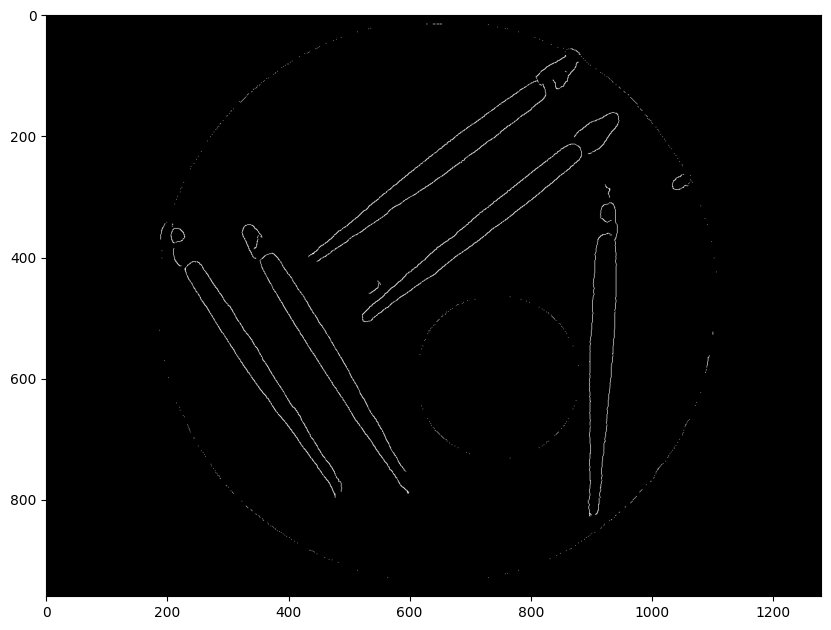

In [20]:
no_circles = remove_circles(edges["edges sigma = 1"], edges["edges sigma = 1"])